In [1]:
import sys
from typing import Any

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.axes import Axes
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from PIL import Image

sys.path.append("..")
from heat.simulation import sample_dissipation, sample_temperature

plt.rcParams.update(
    {
        "font.family": "FreeSerif",
        "mathtext.default": "regular",
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "legend.fontsize": 20,
    }
)

def shrink_cbar(cax, shrink=0.9):
    b = cax.get_position()
    pad = 0.5 * (1.0 -shrink) * b.height
    b.y0 += pad
    b.y1 -= pad
    cax.set_position(b)

### NGS architecture

In [2]:
ngs_im = Image.open("ngs.png", mode="r")

def plot_ngs(ax: Axes) -> None:
    ax.axis("off")
    ax.imshow(ngs_im, interpolation="none")

### Incomplete observations

In [3]:
seed = 1
rng = np.random.default_rng(seed)

# Graph
while True:
    graph = nx.fast_gnp_random_graph(30, 0.1, seed=rng)
    if nx.is_connected(graph):
        break
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()

# Heat system
temperature = sample_temperature([0.5, 0.5], num_nodes, rng)
temperature[temperature == 0.0] = -1.0
dissipation = sample_dissipation([0.1, 2.0], num_edges, rng)
nx.set_edge_attributes(
    graph, {e: 0.5 * np.exp(d) for e, d in zip(graph.edges, dissipation)}, "weight"
)

# Incomplete data
missing_nodes = rng.choice(num_nodes, 2, replace=False)
nonmissing_nodes = np.setdiff1d(np.arange(num_nodes), missing_nodes)
noise = rng.normal(0.0, 0.2, num_nodes)

# Track neighbors of missing nodes
depth = 2
neighbors = set(missing_nodes.copy())
for _ in range(depth):
    new_neighbors = set()
    for node in neighbors:
        new_neighbors.update(list(graph.neighbors(node)))
    neighbors.update(new_neighbors)
neighbors -= set(missing_nodes)
neighbors = np.array(list(neighbors))

pos = nx.spring_layout(graph, k = 2.0 / np.sqrt(num_nodes), seed=seed, weight="weight")
positions = np.stack(list(pos.values()))
positions = (positions - positions.min(axis=0)) / (
    positions.max(axis=0) - positions.min(axis=0)
)
pos = {node: positions[i] for i, node in enumerate(graph.nodes)}
xlim = positions[:, 0].min() - 0.1, positions[:, 0].max() + 0.1
ylim = positions[:, 1].min() - 0.1, positions[:, 1].max() + 0.1


def plot_exact_state(ax: Axes, **kwargs) -> None:
    nx.draw_networkx(graph, ax=ax, node_color=temperature, with_labels=False, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def plot_imperfections(ax: Axes, **kwargs) -> None:
    nx.draw_networkx(
        graph,
        ax=ax,
        node_color=noise[nonmissing_nodes],
        with_labels=False,
        nodelist=nonmissing_nodes,
        **kwargs,
    )
    nx.draw_networkx_nodes(
        graph,
        ax=ax,
        pos=kwargs["pos"],
        nodelist=missing_nodes,
        node_color="k",
        node_shape="s",
        node_size=kwargs["node_size"],
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def plot_incomplete(ax: Axes, **kwargs) -> None:
    nx.draw_networkx(
        graph,
        ax=ax,
        with_labels=False,
        node_color=(temperature + noise)[nonmissing_nodes],
        nodelist=nonmissing_nodes,
        **kwargs,
    )
    nx.draw_networkx_nodes(
        graph,
        ax=ax,
        pos=kwargs["pos"],
        node_color=(temperature + noise)[neighbors],
        nodelist=neighbors,
        linewidths=2.0,
        node_shape="s",
        edgecolors=kwargs["edgecolors"],
        cmap=kwargs["cmap"],
        vmin=kwargs["vmin"],
        vmax=kwargs["vmax"],
        node_size=kwargs["node_size"],
    )
    nx.draw_networkx_nodes(
        graph,
        ax=ax,
        pos=kwargs["pos"],
        nodelist=missing_nodes,
        node_shape="s",
        node_color="k",
        node_size=kwargs["node_size"],
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### Plot

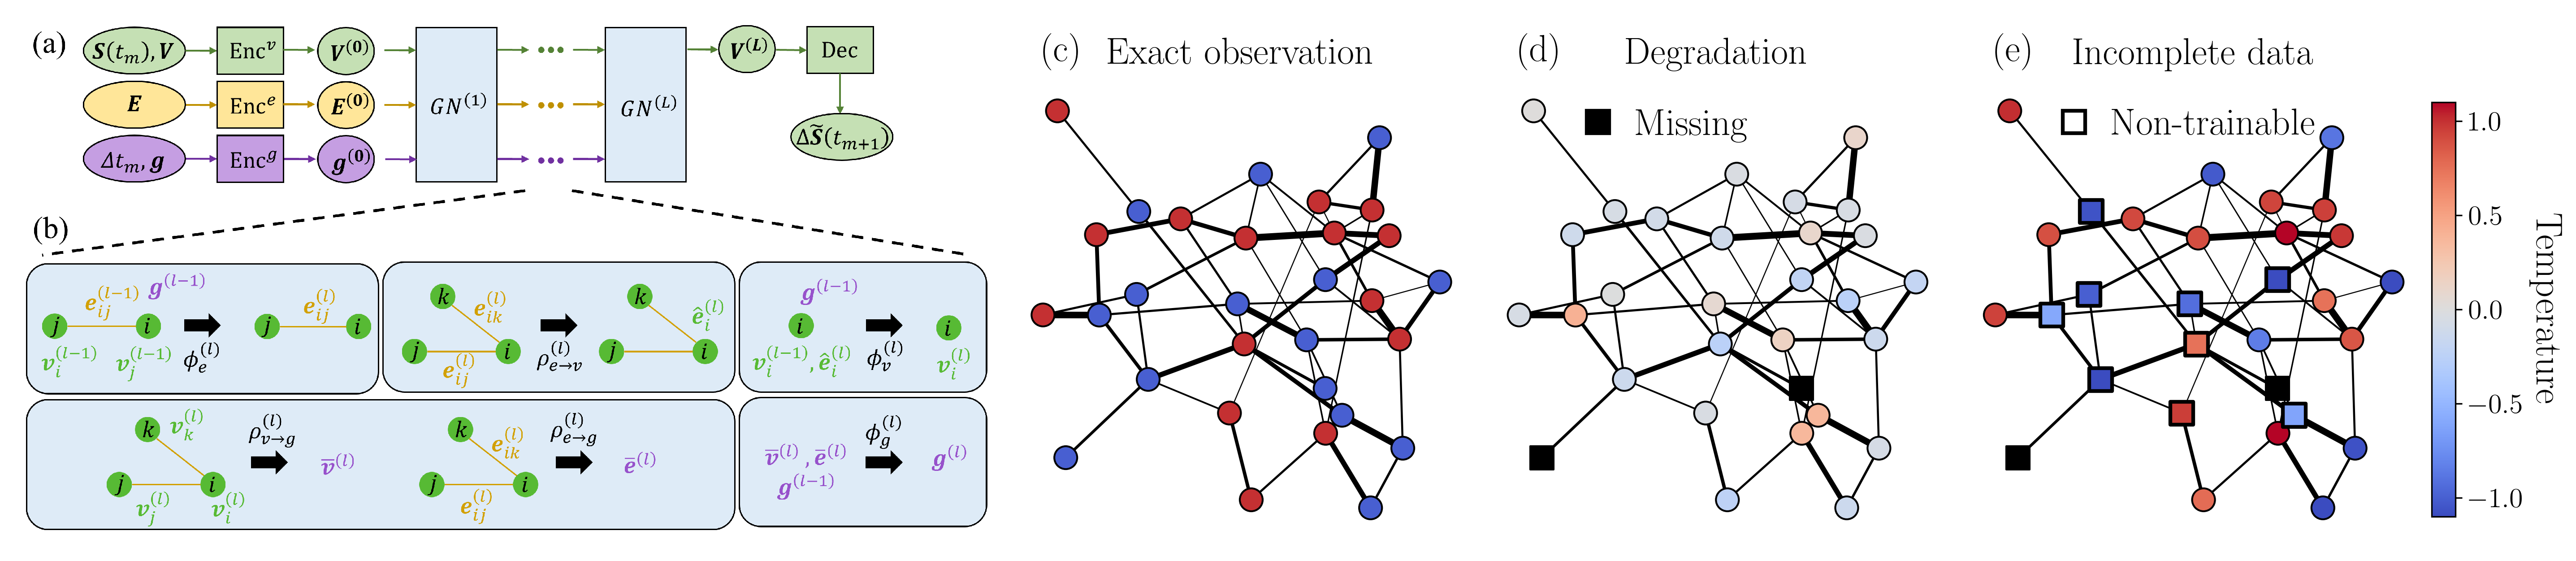

In [4]:
fig = plt.figure(figsize=(20, 5), dpi=300)
gs1 = GridSpec(1, 1, left=0.0, right=0.45)
gs2 = GridSpec(
    1,
    4,
    width_ratios=[1.0, 1.0, 1.0, 0.05],
    hspace=0.0,
    wspace=0.0,
    left=0.41,
    right=0.95,
    bottom=0.0,
)


ax0 = fig.add_subplot(gs1[0], frameon=False)
ax1 = fig.add_subplot(gs2[0], aspect="equal", frameon=False)
ax2 = fig.add_subplot(gs2[1], aspect="equal", frameon=False)
ax3 = fig.add_subplot(gs2[2], aspect="equal", frameon=False)
ax4 = fig.add_subplot(gs2[3])

# Plot
node_kwargs: dict[str, Any] = dict(
    pos=pos, node_size=150, edgecolors="k", vmin=-1.1, vmax=1.1, cmap="coolwarm"
)
edge_kwargs = dict(edge_color="k", width=0.5 * np.exp(dissipation))
plot_ngs(ax0)
plot_exact_state(ax1, **node_kwargs, **edge_kwargs)
plot_imperfections(ax2, **node_kwargs, **edge_kwargs)
plot_incomplete(ax3, **node_kwargs, **edge_kwargs)

# Color bar
sm = ScalarMappable(
    cmap=node_kwargs["cmap"],
    norm=Normalize(vmin=node_kwargs["vmin"], vmax=node_kwargs["vmax"]),
)
fig.colorbar(sm, cax=ax4, location="right", pad=0.0, aspect=1, shrink=2.0)
shrink_cbar(ax4, shrink=0.7)

# Titles
ax1.set_title("Exact observation", pad=0.0)
ax2.set_title("Degradation", pad=0.0)
ax3.set_title("Incomplete data", pad=0.0)

# Labels
ax4.set_ylabel("Temperature", rotation=-90, labelpad=20)

# Legends
legend_kwargs: dict[str, Any] = dict(
    markersize=12, markeredgecolor="k", markeredgewidth=2.0
)
ax2.plot([], [], "s", color="k", label="Missing", **legend_kwargs)
ax3.plot([], [], "s", color="w", label="Non-trainable", **legend_kwargs)
ax2.legend(
    frameon=False, handletextpad=0.0, loc="lower left", bbox_to_anchor=(0.1, 0.78)
)
ax3.legend(
    frameon=False, handletextpad=0.0, loc="lower left", bbox_to_anchor=(0.1, 0.78)
)

# Texts
ax1.text(0.0, 1.125, "(c)")
ax2.text(0.0, 1.125, "(d)")
ax3.text(0.0, 1.125, "(e)")

# fig.savefig("fig1.pdf", bbox_inches="tight")
fig.show()